## Main: In this file, i have used various algorithms to create various recommendation engines using all the collected data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Importing the Dataset collected of all the Hollywood movies till 2020
data = pd.read_csv('Data-till2020.csv')

In [11]:
print(data.shape)
data.head(3)

(6037, 9)


,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,genres,vote_average,vote_count,comb
0,avatar,jamescameron,cchpounder,joeldavidmoore,wesstudi,Action Adventure Fantasy Sci-Fi,7.9,3054.0,cchpounder joeldavidmoore wesstudi jamescamero...
1,pirates of the caribbean: at world's end,goreverbinski,johnnydepp,orlandobloom,jackdavenport,Action Adventure Fantasy,7.1,1238.0,johnnydepp orlandobloom jackdavenport goreverb...
2,spectre,sammendes,christophwaltz,rorykinnear,stephaniesigman,Action Adventure Thriller,6.8,994.0,christophwaltz rorykinnear stephaniesigman sam...


In [12]:
data.isnull().sum()

movie_title      0
director_name    0
actor_1_name     0
actor_2_name     0
actor_3_name     0
genres           0
vote_average     0
vote_count       0
comb             0
dtype: int64

## This is the first appraoch that we are gonna use. This approach is for new or first time users, to whom our model will recommend movies based on rating and genres

<h2>For new Users:</h2>

<h2>Weighted Average Rating for each movie's Average Rating</h2>

I can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.

So, I'll be using IMDB's weighted rating (wr) which is given as :-

<pre>
<b>Weighted Rating (WR) =  (vv+m.R)+(mv+m.C) </b>
</pre>
where,
<pre>
v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report
</pre>

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [13]:
# This function will return n number of movies based on the values of best Weighted Ratings. 
def get_recommendation_based_on_wr(n):
    v = data[data['vote_count'].notnull()]['vote_count'].astype('int')
    R = data[data['vote_average'].notnull()]['vote_average'].astype('int')
    C = data['vote_average'].mean()
    m = data['vote_count'].quantile(0.95)
    data['Weighted_Rating'] = ((R*v)+(C*m))/(v+m)
    return data[['movie_title','Weighted_Rating']].sort_values('Weighted_Rating', ascending=False).head(5)

### Recommending best five movies based on Weighted Rating

In [16]:
get_recommendation_based_on_wr(5)

,movie_title,Weighted_Rating
56,the dark knight,8.401409
1851,the shawshank redemption,8.344950
3331,the godfather,8.001855
5430,avengers: infinity war,7.896013
5674,avengers: endgame,7.868246


<h2>To recommend movies using weighted rating based on genres:</h2>

In above case, we havent considered genres to recommend best movies to a user. We want that the user should also be able to specify what genre(s) of movies he is interested in.

In [17]:
# Changing the deafult index of the dataframe
s = data.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_data = data.drop('genres', axis=1).join(s)
gen_data['genre'] = pd.Series(gen_data['genre'], dtype=object)

In [18]:
def get_recommendation_using_wr_and_genre(genre, percentile=0.85):
    df = gen_data[gen_data['genre'] == genre]
    print(df.shape)
    #Calculating all the components: 
    v = data[data['vote_count'].notnull()]['vote_count'].astype('int')
    R = data[data['vote_average'].notnull()]['vote_average'].astype('int')
    C = data['vote_average'].mean()
    m = data['vote_count'].quantile(0.95)
    df['Weighted_Rating'] = ((R*v)+(C*m))/(v+m)
    df = df.sort_values('Weighted_Rating', ascending=False).head(250)
    return df[['movie_title']]

In [20]:
get_recommendation_using_wr_and_genre('Romance').head(10)

(5, 10)


,movie_title
5339,can't buy my love
4021,sardaar ji
4866,breaking upwards
4252,dil jo bhi kahey...
5226,amor.com


# Content-Based Filtering

### This part is used for recommending movies to an existing users. For now, the user will explicitly specify the movie name to get recommended about similar movies.
<h3>For Existing Users:</h3>
<pre>
I will compute pairwise similarity scores for all movies which will be based on director(s), various actors and genres 
and recommend movies based on that similarity score. 
<h3>Step 1: To create word vector</h3>
<pre>To compute the cosine similarity, we need word vector. For this, we need to calculate the word count of the words in each data['comb'] value

The CountVectorizer or the TfidfVectorizer from scikit learn lets us compute this. The output of this comes as a sparse matrix.
We will use CountVectorizer() instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. </pre>
<h3>Step 2: Computing the cosine similarity</h3>
<pre><b>Cosine Similarity is a measurement that quantifies the similarity between two or more vectors.</b> 
The cosine similarity is the cosine of the angle between two non-zero n-dimensional vectors.
The cosine similarity is described mathematically as the division between the dot product of vectors and the product of the euclidean norms or magnitude of each vector.
</pre>

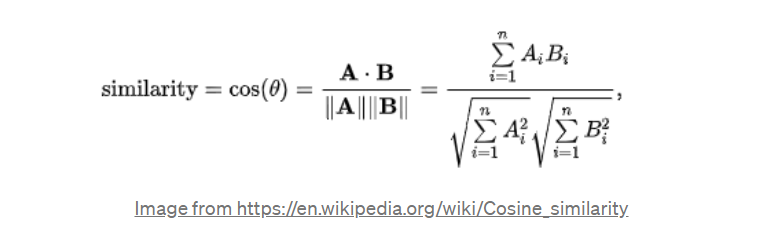
</pre>

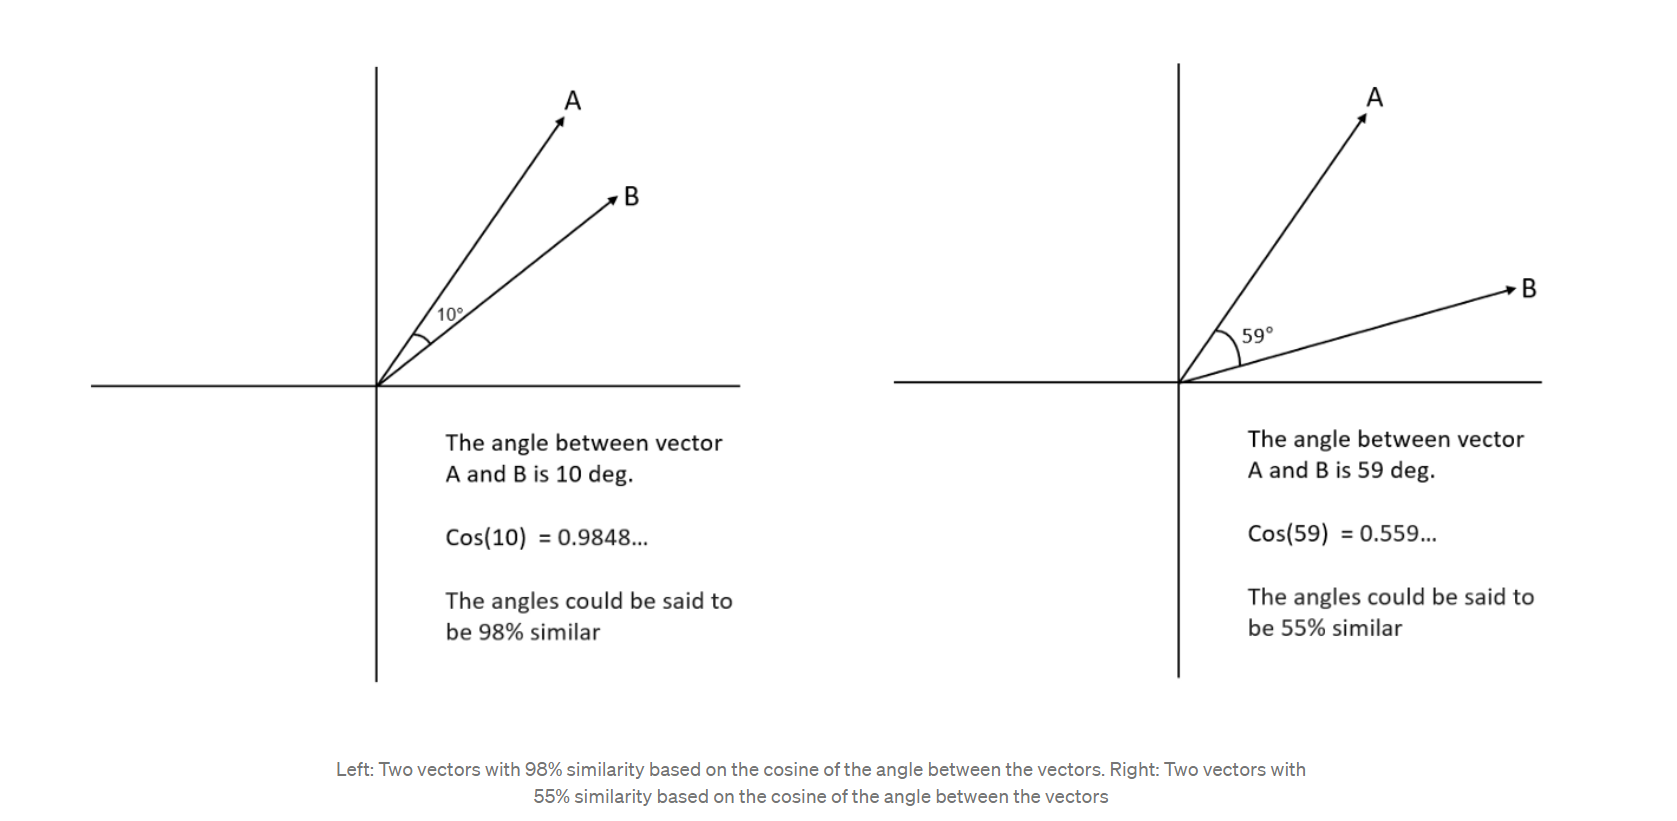

I have implemented both of these steps using a single function

In [21]:
def create_similarity():
    # creating a count matrix 
    cv = CountVectorizer()
    count_matrix = cv.fit_transform(data['comb'])
    # Computing cosine similarity
    similarity = cosine_similarity(count_matrix)
    return data,similarity

<h2>Recommendation</h2>

In [22]:
def get_recommendations(title):
    title = title.lower()
    try:
        data.head()
        similarity.shape
    except:
        data, similarity = create_similarity()
    if title not in data['movie_title'].unique():
        return('Sorry! The movie you requested is not in our database. Please check the spelling or try with some other movies')
    else:
        # Get the index of the movie that matches the title
        index = data.loc[data['movie_title'] == title].index[0]
        
        # Get the pairwsie similarity scores of all movies with that movie
        lst_scores = list(enumerate(similarity[index]))
        lst_scores = sorted(lst_scores, key = lambda x:x[1] ,reverse=True)
        
        # Get the scores of the 10 most similar movies
        lst_scores = lst_scores[1:11] # excluding first item since it is the requested movie itself
        
        movie_indices = [i[0] for i in lst_scores]
        
        # Return the top 10 most similar movies
        return data['movie_title'].iloc[movie_indices]

### Recommend Movies which are similar to "the dark knight rises" wrt. genres, actor(s), and director(s) 

In [23]:
get_recommendations("the dark knight rises")

85                         inception
56                   the dark knight
646     sin city: a dame to kill for
1405                    premium rush
67       g.i. joe: the rise of cobra
1072             miracle at st. anna
5930                            7500
106                    batman begins
1539                          looper
851                            shaft
Name: movie_title, dtype: object